In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

from PIL import Image 
import PIL 
  
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('dataset/cloud_use.csv')
#df= df.dropna()
#df.isna().sum()
len(df)

25216

In [4]:
df.columns

Index(['cc', 'time_stamp', 'DATE (MM/DD)', 'MST',
       'Global CMP22 (vent/cor) [W/m^2]', 'Direct sNIP [W/m^2]',
       'Azimuth Angle [degrees]', 'Tower Dry Bulb Temp [deg C]',
       'Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]',
       'Tower RH [%]', 'Total Cloud Cover [%]', 'Peak Wind Speed @ 6ft [m/s]',
       'Avg Wind Direction @ 6ft [deg from N]', 'Station Pressure [mBar]',
       'Precipitation (Accumulated) [mm]', 'Snow Depth [cm]', 'Moisture',
       'Albedo (CMP11)', 'date', 'time', 'p30', 'p60', 'p90', 'p120'],
      dtype='object')

In [4]:
df['zenith'] = np.degrees(np.arccos(df['Albedo (CMP11)']))

c:\users\aishu\miniconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
y_3class = []
for i in df['Total Cloud Cover [%]']:
    if(i<0):
        y_3class.append(-1)
    elif(i<11):
        y_3class.append(0)
    else:
        y_3class.append(1)#[0 if i in [-1,0] else 1 for i in df['Total Cloud Cover [%]']]
len(y_3class)

25216

In [156]:
IMG_SIZE = 128

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [157]:
data_dir = 'dataset/1_0/'
batch_size = 32
img_height = 100
img_width = 100

In [160]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25216 files belonging to 3 classes.
Using 17652 files for training.


In [161]:
class_names = train_ds.class_names
print(class_names)

['cloud', 'night', 'no_cloud']


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25216 files belonging to 3 classes.
Using 7564 files for validation.


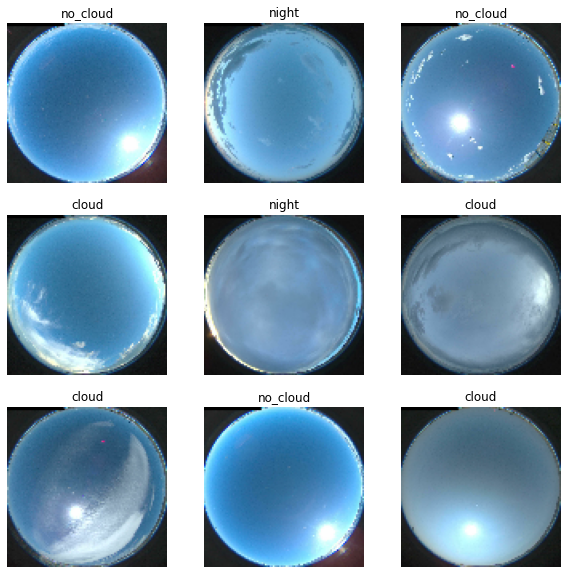

In [172]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
num_classes = 3

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)       

In [26]:
epochs=10
checkpoint_filepath = '/dataset/models/model_3class'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#model.fit(epochs=epochs, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[model_checkpoint_callback])

Epoch 1/10
552/552 [==============================] - 78s 141ms/step - loss: 0.3610 - accuracy: 0.8528 - val_loss: 0.3220 - val_accuracy: 0.8720
Epoch 2/10
552/552 [==============================] - 84s 153ms/step - loss: 0.2894 - accuracy: 0.8857 - val_loss: 0.2928 - val_accuracy: 0.8924
Epoch 3/10
552/552 [==============================] - 84s 153ms/step - loss: 0.2679 - accuracy: 0.8934 - val_loss: 0.3355 - val_accuracy: 0.8638
Epoch 4/10
552/552 [==============================] - 85s 155ms/step - loss: 0.2528 - accuracy: 0.9000 - val_loss: 0.2872 - val_accuracy: 0.8942
Epoch 5/10
552/552 [==============================] - 85s 154ms/step - loss: 0.2437 - accuracy: 0.9027 - val_loss: 0.2440 - val_accuracy: 0.9086
Epoch 6/10
552/552 [==============================] - 85s 155ms/step - loss: 0.2309 - accuracy: 0.9098 - val_loss: 0.2683 - val_accuracy: 0.8997
Epoch 7/10
552/552 [==============================] - 85s 154ms/step - loss: 0.2185 - accuracy: 0.9145 - val_loss: 0.2353 - val_ac

In [29]:
model.save_weights('./checkpoints/my_checkpoint')

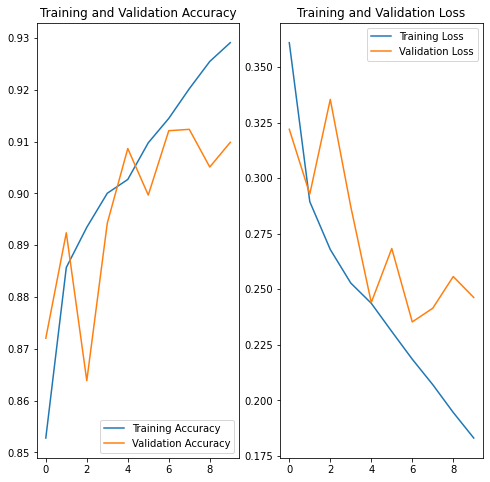

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
target = []
for i in range(len(list(val_ds))):#[0][-1]
    target.extend(np.array(list(val_ds)[i][-1]))
    
target = np.array(target)

In [61]:
pred = model.predict(val_ds)
pred = np.argmax(pred,axis=-1)
pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [68]:
from sklearn.metrics import classification_report
report = classification_report(target, pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       cloud       0.93      0.97      0.95      5879
    no_cloud       0.85      0.66      0.74      1204
    unk_rain       0.80      0.76      0.78       481

    accuracy                           0.91      7564
   macro avg       0.86      0.80      0.82      7564
weighted avg       0.91      0.91      0.91      7564



# PART 2

In [3]:
y_reg = []
for i in df['Total Cloud Cover [%]']:
    if(i<0):
        continue#y_3class.append(-1)
    elif(i<11):
        continue#y_3class.append(0)
    else:
        y_reg.append(i)#[0 if i in [-1,0] else 1 for i in df['Total Cloud Cover [%]']]
len(y_reg)

19665

In [6]:
y_reg_timestamp = []
for i in range(len(df)):
    it = df['Total Cloud Cover [%]'][i]
    if(it<0):
        continue#y_3class.append(-1)
    elif(it<11):
        continue#y_3class.append(0)
    else:
        y_reg_timestamp.append(df['time_stamp'][i])#[0 if i in [-1,0] else 1 for i in df['Total Cloud Cover [%]']]
len(y_reg_timestamp)

19665

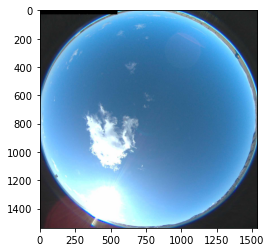

In [4]:
#sub = pd.DataFrame()
im = plt.imread('dataset/1_0/cloud/'+'0106_0106101000.jpg')
plt.imshow(im)

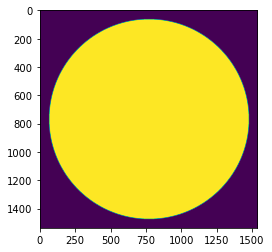

In [5]:
def create_circular_mask(h, w, center=None, radius=None):
    center = (int(w/2), int(h/2))
    #if radius is None: # use the smallest distance between the center and image walls
    radius = int(165 * w/180 * 0.5)#min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
h,w,_ = im.shape
mask = create_circular_mask(h,w)
plt.imshow(mask)

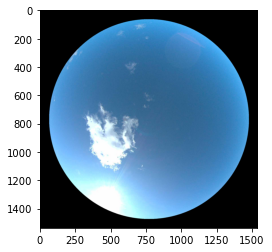

In [6]:
im2 = im.copy()
im2[~mask] = 0
#plt.plot(Is,Js,'ro')
plt.imshow(im2)

In [7]:
X = []
import os
i = 0
for image in os.listdir('dataset/1_0/cloud'):
    #print(image.split('.')[0])
    #df[df['time_stamp']=='0101_0101075000'][['Azimuth Angle [degrees]','zenith','Total Cloud Cover [%]' ]]
    
    im = plt.imread('dataset/1_0/cloud/'+image)
    im2 = im.copy()
    im2[~mask] = 0
    im2 = resize_and_rescale(im2)
    i+=1
    X.append(im2)

In [10]:
len(X), len(y_reg)

(19665, 19665)

In [22]:
new_model = tf.keras.models.load_model('saved_model/cloud_seg')


In [47]:
x_ = np.expand_dims(X[1],0)
x_.shape

(1, 128, 128, 3)

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [110]:
def predict_cc(x):
    x_ = np.expand_dims(x,0)
    p = new_model.predict(x_)
    p = create_mask(p)
    (unique, counts) = np.unique(p, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    cc = frequencies[-1,1] / np.sum(mask_s)
    return cc,p


In [111]:
pred_cc = []
for img in X:
    cc,_ = predict_cc(img)
    pred_cc.append(cc)
    

print(len(pred_cc),len(y_reg))

19665 19665


In [60]:
np.mean(np.array(pred_cc) - np.array(y_reg))

-56.72117802289919

In [112]:
df_pred = pd.DataFrame()
df_pred['base'] = y_reg
df_pred['pred'] = pred_cc
df_pred.to_csv('cc_pred.csv',index=False)

In [9]:
df_pred.to_csv('cc_pred.csv',index=False)

In [11]:
df_pred = pd.read_csv('cc_pred.csv')


In [12]:
df_pred.head()

,base,pred,p_pred,diff,timestamp
0,13,0.537301,53.730100,40.730100,0101_0101075000
1,25,0.635413,63.541281,38.541281,0101_0101080000
2,37,0.573862,57.386153,20.386153,0101_0101081000
3,15,0.225565,22.556461,7.556461,0101_0101082000
4,18,0.244261,24.426138,6.426138,0101_0101083000


In [8]:
df_pred['timestamp'] = y_reg_timestamp


In [113]:
df_pred['p_pred'] = np.array(pred_cc)*100
df_pred.head()

,base,pred,p_pred
0,13,0.537301,53.730100
1,25,0.635413,63.541281
2,37,0.573862,57.386153
3,15,0.225565,22.556461
4,18,0.244261,24.426138


In [114]:
df_pred['diff'] = np.absolute(df_pred['p_pred'] - df_pred['base'])
df_pred.head()

,base,pred,p_pred,diff
0,13,0.537301,53.730100,40.730100
1,25,0.635413,63.541281,38.541281
2,37,0.573862,57.386153,20.386153
3,15,0.225565,22.556461,7.556461
4,18,0.244261,24.426138,6.426138


In [141]:
def display(display_list):
    plt.figure(figsize=(6, 6))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i//2])
        if(display_list[i].shape[-1]==1):
            plt.imshow(display_list[i][:,:,0])
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

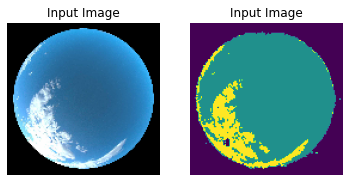

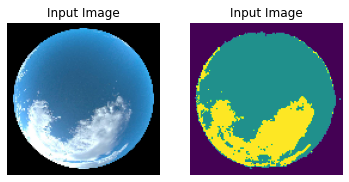

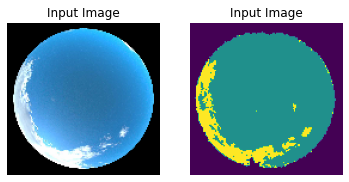

In [142]:
i=0
for h in df_pred[df_pred['diff']<5].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    if(i==2):
        break
    i+=1

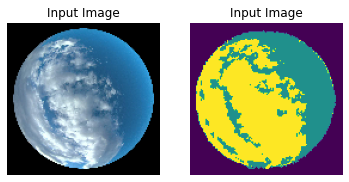

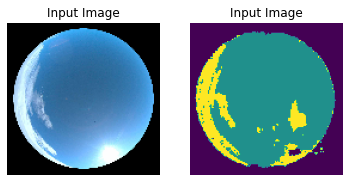

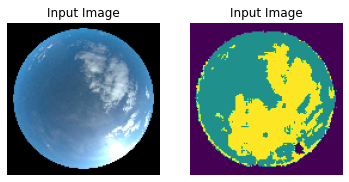

In [145]:
i=0
for h in df_pred[df_pred['diff'].between(20,30)].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    if(i==2):
        break
    i+=1

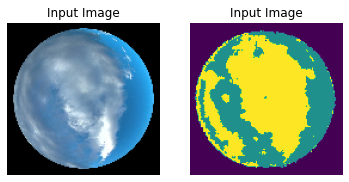

13 53.73


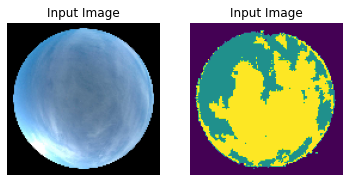

14 58.83


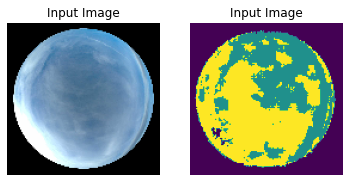

12 56.04


In [149]:
# Transperancy failing
i=0
for h in df_pred[df_pred['diff'].between(40,50)].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    print(y_reg[h],round(c*100,2))
    if(i==2):
        break
    i+=1

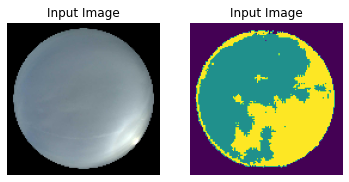

98 42.47


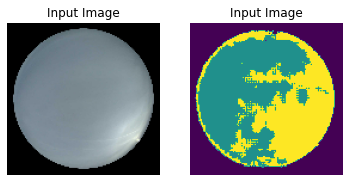

99 44.94


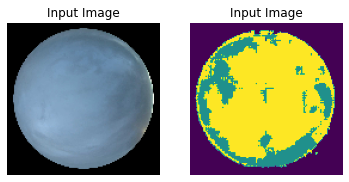

23 73.11


In [150]:
# NO sky failing
i=0
for h in df_pred[df_pred['diff'].between(50,60)].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    print(y_reg[h],round(c*100,2))
    if(i==2):
        break
    i+=1

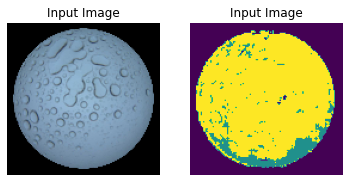

17 85.88


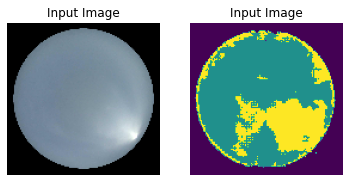

94 30.66


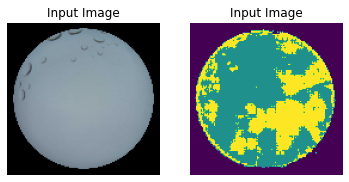

98 37.72


In [151]:
#RAIN
i=0
for h in df_pred[df_pred['diff'].between(60,70)].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    print(y_reg[h],round(c*100,2))
    if(i==2):
        break
    i+=1

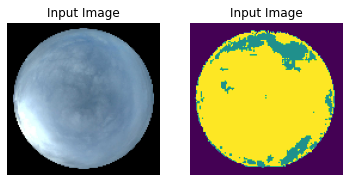

14 84.16


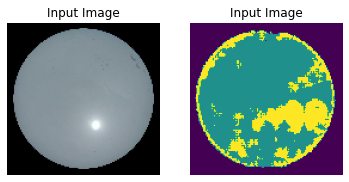

97 26.22


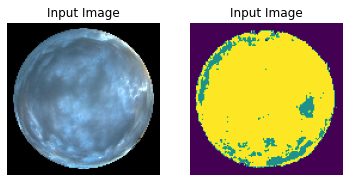

14 87.15


In [154]:
i=0
for h in df_pred[df_pred['diff'].between(70,80)].index:
    dl = []

    dl.append(X[h])
    c,p = predict_cc(X[h])
    dl.append(p)
    #plt.subplot(4,1,i+1)
    display(dl)
    print(y_reg[h],round(c*100,2))
    if(i==2):
        break
    i+=1

{'whiskers': [<matplotlib.lines.Line2D at 0x1e06569e808>,
 'caps': [<matplotlib.lines.Line2D at 0x1e06be29f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e06569eb08>],
 'medians': [<matplotlib.lines.Line2D at 0x1e068280408>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e06855e248>],
 'means': []}

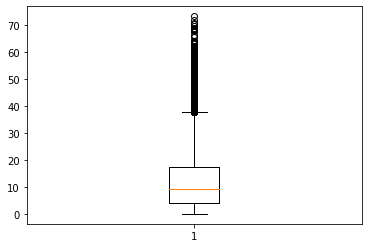

In [116]:
plt.boxplot(df_pred['diff'])

(128, 128, 1)


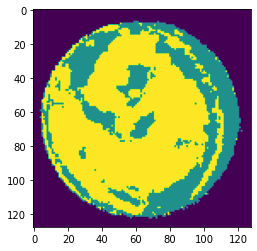

In [49]:
p = new_model.predict(x_)
p = create_mask(p)
print(p.shape)
plt.imshow(p[:,:,0])

In [50]:
(unique, counts) = np.unique(p, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 5801],
       [   1, 3718],
       [   2, 6865]], dtype=int64)

Text(0.5, 1.0, '0.557373046875')

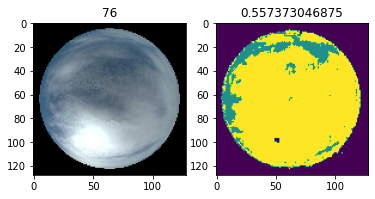

In [107]:
n = 2500#1500,1000
plt.subplot(121)
plt.imshow(X[n])
plt.title(y_reg[n])
cc,s = predict_cc(X[n])
plt.subplot(122)
plt.imshow(s[:,:,0])
plt.title(cc)

In [ ]:
#Bad at full cloudy and bright blue

# Part 3

In [96]:
reg_data = []
for i in range(len(y_reg)):
    reg_data.append((X[i], y_reg[i]])

In [11]:
#d1 = tf.data.Dataset.from_tensors(X)
#d2 = tf.data.Dataset.from_tensors(y_reg)
dataset_reg = tf.data.Dataset.from_tensor_slices((X, y_reg))#tf.data.Dataset.zip((d1, d2)) #tf.data.Dataset.from_tensors((reg_data))

In [12]:
DATASET_SIZE = len(y_reg)
train_size = int(0.5 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)



full_dataset = dataset_reg.shuffle(DATASET_SIZE )
train_dataset = full_dataset.take(train_size)
temp_dataset = full_dataset.skip(train_size)
val_dataset = temp_dataset.take(val_size)

In [13]:
batch_size=128    #TRY 128

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
IMG_SHAPE = (128,128,3)
epochs=5
chanDim = -1
checkpoint_filepath = './checkpoints3/my_checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
prediction_layer = tf.keras.layers.Dense(1)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dense(80, activation='relu')(x),
#x = layers.BatchNormalization(axis=chanDim)(x),
x = layers.Dropout(0.5)(x)
x = layers.Dense(80, activation='relu')(x),
x = layers.Dropout(0.5)(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="mean_absolute_percentage_error")

history = model3.fit(
                    train_dataset,
  validation_data=val_dataset,
  epochs=epochs,callbacks=[model_checkpoint_callback])

Epoch 1/5
123/123 [==============================] - 156s 1s/step - loss: 65.0398 - val_loss: 57.9969
Epoch 2/5
123/123 [==============================] - 159s 1s/step - loss: 61.1313 - val_loss: 57.8118
Epoch 3/5
123/123 [==============================] - 164s 1s/step - loss: 60.1979 - val_loss: 57.6912
Epoch 4/5
123/123 [==============================] - 156s 1s/step - loss: 59.8113 - val_loss: 57.1740
Epoch 5/5
123/123 [==============================] - 151s 1s/step - loss: 59.0670 - val_loss: 55.9039


In [15]:
chanDim = -1
img_height, img_width,_ = X[0].shape
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
    
  #layers.Flatten(),
  #layers.Dense(80),
  #layers.Activation("relu"),
  #layers.BatchNormalization(axis=chanDim),
  layers.Dropout(0.5),
  layers.Dense(1, activation="linear"),
  
])

#opt = Adam(lr=1e-2)
model2.compile(optimizer='adam',
              loss="mean_absolute_percentage_error")

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)      

In [16]:
epochs=10
checkpoint_filepath = './checkpoints2/my_checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#model.fit(epochs=epochs, callbacks=[model_checkpoint_callback])model.save_weights('./checkpoints/my_checkpoint')

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

history2 = model2.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,callbacks=[model_checkpoint_callback])

Epoch 1/10
77/77 [==============================] - 238s 3s/step - loss: 62.5558 - val_loss: 59.8340
Epoch 2/10
77/77 [==============================] - 241s 3s/step - loss: 58.8158 - val_loss: 57.6529
Epoch 3/10
77/77 [==============================] - 301s 4s/step - loss: 56.0263 - val_loss: 39.0393
Epoch 4/10
77/77 [==============================] - 293s 4s/step - loss: 32.5003 - val_loss: 18.8785
Epoch 5/10
77/77 [==============================] - 418s 5s/step - loss: 22.7516 - val_loss: 14.5346
Epoch 6/10
77/77 [==============================] - 675s 9s/step - loss: 20.1757 - val_loss: 19.3075
Epoch 7/10
77/77 [==============================] - 631s 8s/step - loss: 17.4363 - val_loss: 13.1059
Epoch 8/10
77/77 [==============================] - 950s 12s/step - loss: 18.1887 - val_loss: 16.4673
Epoch 9/10
77/77 [==============================] - 914s 12s/step - loss: 17.1260 - val_loss: 13.7189
Epoch 10/10
77/77 [==============================] - 657s 9s/step - loss: 17.0671 - val_l

In [17]:
history2_ = model2.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,callbacks=[model_checkpoint_callback])

Epoch 1/10
77/77 [==============================] - 810s 7s/step - loss: 17.1733 - val_loss: 15.9928
Epoch 2/10
77/77 [==============================] - 710s 9s/step - loss: 16.1989 - val_loss: 24.6794
Epoch 3/10
77/77 [==============================] - 751s 10s/step - loss: 17.7601 - val_loss: 14.0014
Epoch 4/10
77/77 [==============================] - 1042s 14s/step - loss: 16.0549 - val_loss: 13.5938
Epoch 5/10
77/77 [==============================] - 913s 12s/step - loss: 15.8873 - val_loss: 14.1135
Epoch 6/10
77/77 [==============================] - 1140s 15s/step - loss: 15.3076 - val_loss: 12.8125
Epoch 7/10
77/77 [==============================] - 1254s 16s/step - loss: 14.9058 - val_loss: 12.7306
Epoch 8/10
77/77 [==============================] - 3123s 41s/step - loss: 16.2490 - val_loss: 13.5667
Epoch 9/10
77/77 [==============================] - 2627s 34s/step - loss: 15.4454 - val_loss: 14.5462
Epoch 10/10
77/77 [==============================] - 2510s 33s/step - loss: 15.

In [179]:
preds = model3.predict(val_dataset)
target3 = []
for i in range(len(list(val_dataset))):#[0][-1]
    target3.extend(np.array(list(val_dataset)[i][-1]))
    
target3 = np.array(target)

In [181]:
print(np.max(preds))
preds = [float(i) if i<100 else 100 for i in preds]
np.max(preds)

21.44601


21.44601058959961

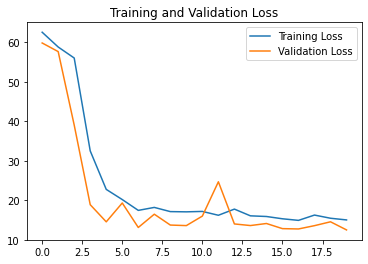

In [21]:


loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()